# SIPMS WAVEFORMS WITH NOISE

The noise of the SiPMs is generated by a simple class that samples the sensors' noise distributions (from dark current).
The noise distributions are stored as an ascii table in the file [NoiseSiPM_NEW.dat](../../NoiseSiPM_NEW.dat)

. The format of the table is the following:
1. Columns ranging from 1 to last contain the number of entries for a given number of photoelectrons.
2. Each row from 1 to last correspond to one SiPM.
3. The first row stores the number of photoelectrons corresponding to each column.
4. The first column labels each row with the sensorID.
5. The value at 0,0 is meaningless (it is there for consistency in the table shape).


   Meaningless  |   #pes 1      |    #pes 2    |    #pes 3   |   ...   
  ------------- | ------------- | ------------ | ----------- | ------- 
    sensorID 1  |  #entries 1   |  #entries 2  |  #entries 3 |   ...    
    sensorID 2  |  #entries 1   |  #entries 2  |  #entries 3 |   ...    
    sensorID 3  |  #entries 1   |  #entries 2  |  #entries 3 |   ...    
       ...      |      ...      |     ...      |     ...     |   ...   
       
       
This table is read by the [RandomSampling](../../Core/RandomSampling.dat) class listed below

In [6]:
# %load ../../Core/RandomSampling.py
'''
    Defines a class for random sampling
'''
from __future__ import print_function
import numpy as np

class SiPMsNoiseSampler:
    def __init__(self,filename,index_map,sample_size = 1,smear = True):
        print("Initializing SiPMNoiseSampler",end=" ")
        data = np.loadtxt(filename )

        self.xbins = data[0,1:] # xbins are stored in the first line. First value is dummy.
        self.dx    = np.diff(self.xbins)[0]*0.5 # half of the bin size
        data = data[ np.where(map(index_map.__contains__,data[:,0]))[0] ] #Remove masked channels

        self.probs = np.apply_along_axis( lambda probs: probs/np.sum(probs), 1, data[:,1:] ) # normalize probabilities
        self.nsamples = sample_size
        self.nsensors = len(self.probs)
        self.output_shape = (self.nsensors,self.nsamples)

        self._sample_sensor = lambda probs: np.random.choice( self.xbins, size = self.nsamples, p=probs )
        self._discrete_sampler = lambda: np.apply_along_axis( self._sample_sensor, 1, self.probs )
        self._continuous_sampler = lambda: self._discrete_sampler() + np.random.uniform(-self.dx,self.dx,size=self.output_shape)

        self._sampler = self._continuous_sampler if smear else self._discrete_sampler
        print("OK")

    def Sample( self ):
        return self._sampler()


#### Random sampling class
This class samples the distribution of the number of photoelectrons for each (unmasked) SiPM. The sampling is made by choosing from the list of #pes (first row in the ascii file) with weights computed from the #entries for each SiPM. Optionally, the #pes can be smeared so it does not retrieve discrete values.

The constructor of this class takes the name of the ascii file containing the table (the path must be included), a map relating sensorIDs with indices in the table, the size of the sample and a flag to choose between discrete or continuous output.

#### Implementation in DIOMIRA
The changes in DIOMIRA are minimal:

1) A line including the [RandomSampling](../../Core/RandomSampling.dat) class

In [ ]:
from RandomSampling import SiPMsNoiseSampler

2) The simulate_sipm_response function now takes an instance of the RandomSampling class and adds the result of the Sample mathod to the input:

In [ ]:
def simulate_sipm_response(event_number,sipmrd_,sipms_noise_sampler):
    """
    Add noise with the SiPMNoiseSampler class and return the noisy waveform.
    """
    return sipmrd_[event_number] + sipms_noise_sampler.Sample()

3) An instance of the [RandomSampling](../../Core/RandomSampling.dat) class is created before opening the outputfile:

In [ ]:
# Map of the SiPMs' sensorID to the index used by tables
index_map = { sipm_t[i][0] : i for i in range(sipm_t.shape[0]) }
# Create instance of the noise sampler
sipms_noise_sampler_ = SiPMNoiseSampler("../data/NoiseSiPM_NEW.dat",index_map,SIPMWL,True)


Furthermore, the true waveform of the SiPMs is stored in the TWF group. This required the modification of some functions and renaming some variables for the PMTs, although their behaviour remains unchanged (those modifications include some in the [Nh5.py](../../Core/Nh5.py) file). The two functions added to DIOMIRA were:

In [ ]:
def store_sipm_twf(event, table, TWF):
    """
    Store SiPM TWF in table
    """
    row = table.row
    for isipm,twf in TWF.items():
        for t,e in zip(twf.time_us, twf.amp_pes):
            row['event'] = event
            row['sipm'] = isipm
            row['time_us'] = t
            row['amp_pes'] = e
            row.append()
    table.flush()


def sipm_twf_signal(event_number,sipmrd):
    '''
        Removes zeros from SiPM RD.
    '''
    out = {}
    for index,wfm in enumerate(sipmrd[event_number]):
        time_us = np.where( wfm > 0. )[0]
        if not time_us.any(): continue
        amp_pes = wfm[time_us]
        out[index] = pd.DataFrame( {'time_us':time_us, 'amp_pes':amp_pes} )
    return out

And the implementation in the code required the replication of the code made for the PMTs:

In [ ]:
sipm_twf_table = h5out.create_table( twfgroup, "SiPM", SiPM_TWF, "Store for SiPMs TWF",
                                     tables.Filters(complib=CLIB, complevel=CLEVEL) )

sipm_twf_table.cols.event.create_index()

sipmrwf = h5out.create_earray(h5out.root.RD, "sipmrwf",
                              atom=tables.Float32Atom(),
                              shape=(0, NSIPM, SIPMWL),
                              expectedrows=NEVENTS_DST)

# WITHIN LOOP
trueSiPM = sipm_twf_signal(i,sipmrd_)
store_sipm_twf(i, sipm_twf_table, trueSiPM)
dataSiPM = simulate_sipm_response(i,sipmrd_,sipms_noise_sampler_)
dataSiPM.astype(float)
sipmrwf.append(dataSiPM.reshape(1, NSIPM, SIPMWL))
sipmrwf.flush()

# Running DIOMIRA

In [9]:
run DIOMIRA.py -c ../Config/DIOMIRA_default.csv

Debug level = INFO
input path =/Users/Gonzalo/github/IC/data/; output path = /Users/Gonzalo/github/IC/data/; file_in =in0.h5 file_out =out0.h5
first event = 0 last event = 10 nof events requested = 10 
Compression library = zlib Compression level = 1 
nof PMTs = 12 nof  SiPMs = 1789 nof events in input DST = 100 
lof SiPM WF = 800000 lof PMT WF (MC) = 800 lof PMT WF (FEE) = 32000
Initializing SiPMNoiseSampler OK
-->event number =0
-->event number =1
-->event number =2
-->event number =3
-->event number =4
-->event number =5
-->event number =6
-->event number =7
-->event number =8
-->event number =9
DIOMIRA has run over 9 events in 19.5378940105 seconds
Leaving Diomira. Safe travels!


# Data check

In [6]:
from __future__ import print_function
%matplotlib inline
%load_ext autoreload
%autoreload 2
import cProfile
import pandas as pd
import tables as tb
import numpy as np
from Util import *
import time
import mplFunctions as mpl
import wfmFunctions as wfm
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
#%load_ext line_profiler
#%load_ext memory_profiler
print(time.strftime("%d/%m/%Y"))
print(time.strftime("%H:%M:%S"))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
10/10/2016
23:35:41


In [7]:
#%more ../Config/DIOMIRA_NA_ZLIB_test.csv

In [13]:
cd ../../Cities/

/Users/Gonzalo/github/IC/Cities


In [ ]:
#### move to where data is stored
cd ../data/

In [11]:
%ls .

#NoiseSiPM_NEW.dat#
NoiseSiPM_NEW.dat
NoiseSiPM_NEW.root
Untitled.ipynb
dst_NEXT_v0_08_02_Kr_ACTIVE_0_0_5bar_MCRD_10000.root.h5*
in0.h5@
out0.h5


In [12]:
# open file and check its contents
h5f = tb.open_file('out0.h5')
print(h5f)

out0.h5 (File) ''
Last modif.: 'Mon Oct 10 23:36:10 2016'
Object Tree: 
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
/MC (Group) ''
/MC/FEE (Table(1,)) 'EP-FEE parameters'
/MC/MCTracks (Table(806,), zlib(1)) ''
/RD (Group) ''
/RD/pmtrwf (EArray(10, 12, 32000), shuffle, zlib(1)) ''
/RD/sipmrwf (EArray(10, 1789, 800), shuffle, zlib(1)) ''
/Sensors (Group) ''
/Sensors/DataPMT (Table(12,)) ''
/Sensors/DataSiPM (Table(1789,)) ''
/TWF (Group) ''
/TWF/PMT (Table(141,), shuffle, zlib(1)) 'Store for PMTs TWF'
/TWF/SiPM (Table(1007,), shuffle, zlib(1)) 'Store for SiPMs TWF'



In [ ]:
# define useful variables
wfm = h5f.root.RD.sipmrwf   # Noisy waveform
twfm = h5f.root.TWF.SiPM    # True waveform
print(wfm.shape,twfm.shape) # Nevts Nsipms Nsamples

In [16]:
### Bigger pictures
plt.rcParams['figure.figsize'] = (12, 8)

##### Some functions to plot waveforms

In [17]:
def plotBest(evt = 0):
    '''
        Plot the noisy waveform of the SiPM with greatest charge and superimpose the true waveform.
    '''
    #Find SiPM with greatest peak
    maxsipm = np.unravel_index(wfm[evt,:,:].argmax(),wfm[evt,:,:].shape)[0]
    print("SiPM with greatest peak is at index {} with ID {}".format(maxsipm,h5f.root.Sensors.DataSiPM[maxsipm][0]))
    # Plot noisy waveform in red and noiseless waveform in blue
    true_times, true_amps = zip(*[ (row['time_us'],row['amp_pes']) for row in twfm.iterrows() if row['event'] == evt and row['sipm'] == maxsipm ])
    plt.plot(wfm[evt,maxsipm,:])
    plt.plot(true_times,true_amps)
    
def plotBestGroup(evt = 0, nsipms = 6, nrows = 2, ncols = 3):
    '''
        Plot the noisy and true waveforms of the nsipms SiPMs with greatest charge.
    '''
    #Find SiPM with greatest peak
    sipms = sorted( enumerate(wfm[evt]), key = lambda x: max(x[1]), reverse = True )[:nsipms]
    plt.figure(figsize=(45,60))
    f, axes = plt.subplots(nrows, ncols)
    i,j=0,0
    for sipm_index, sipm_wfm in sipms:
        try:
            true_times, true_amps = zip(*[ (row['time_us'],row['amp_pes']) for row in twfm.iterrows() if row['event'] == evt and row['sipm'] == sipm_index ])
        except:
            continue
        if j==ncols:
            i,j = i+1,0
        axes[i,j].plot(sipm_wfm)
        axes[i,j].plot(true_times,true_amps)
        j += 1
        
    [ plt.setp([a.get_xticklabels() for a in axes[i, :]], visible=False) for i in range(0,nrows-1) ]
    [ plt.setp([a.get_yticklabels() for a in axes[:, i]], visible=False) for i in range(1,ncols) ]
    

SiPM with greatest peak is at index 331 with ID 6011


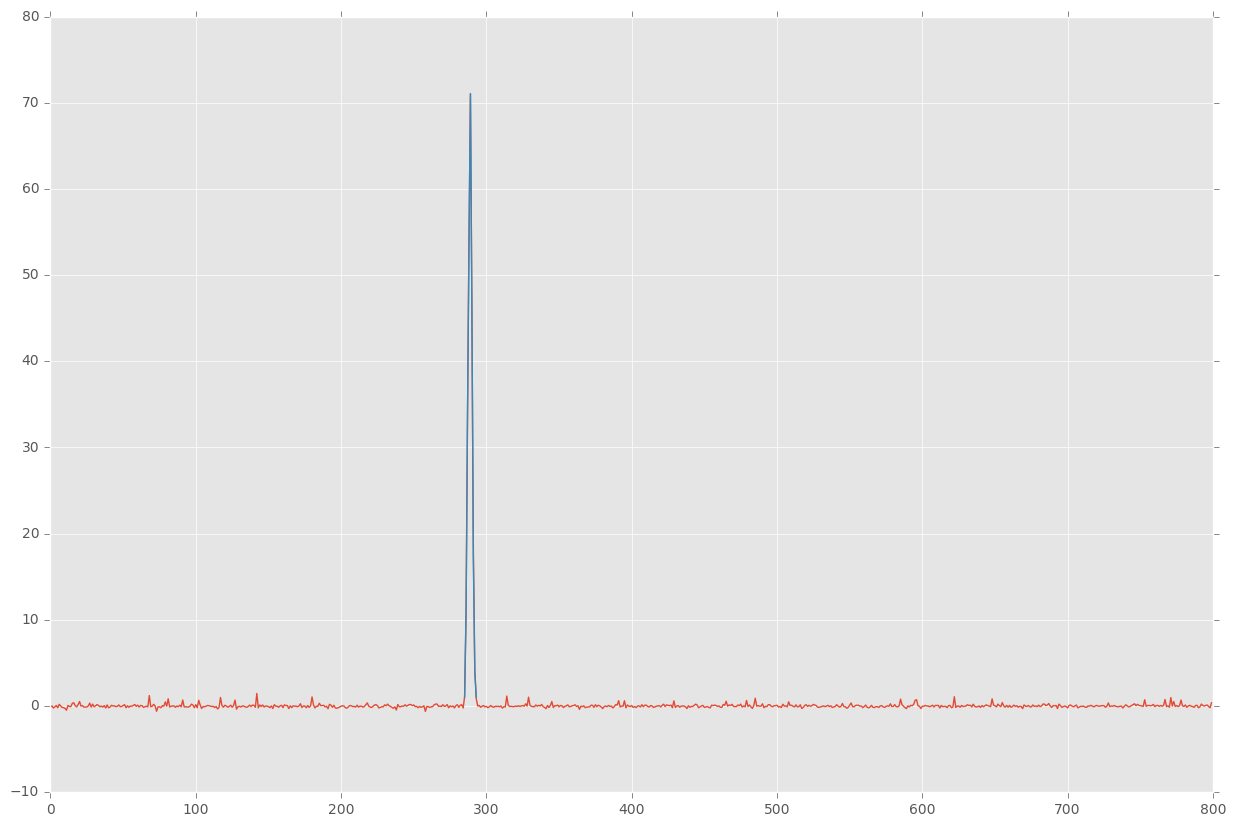

In [56]:
plotBest(0)

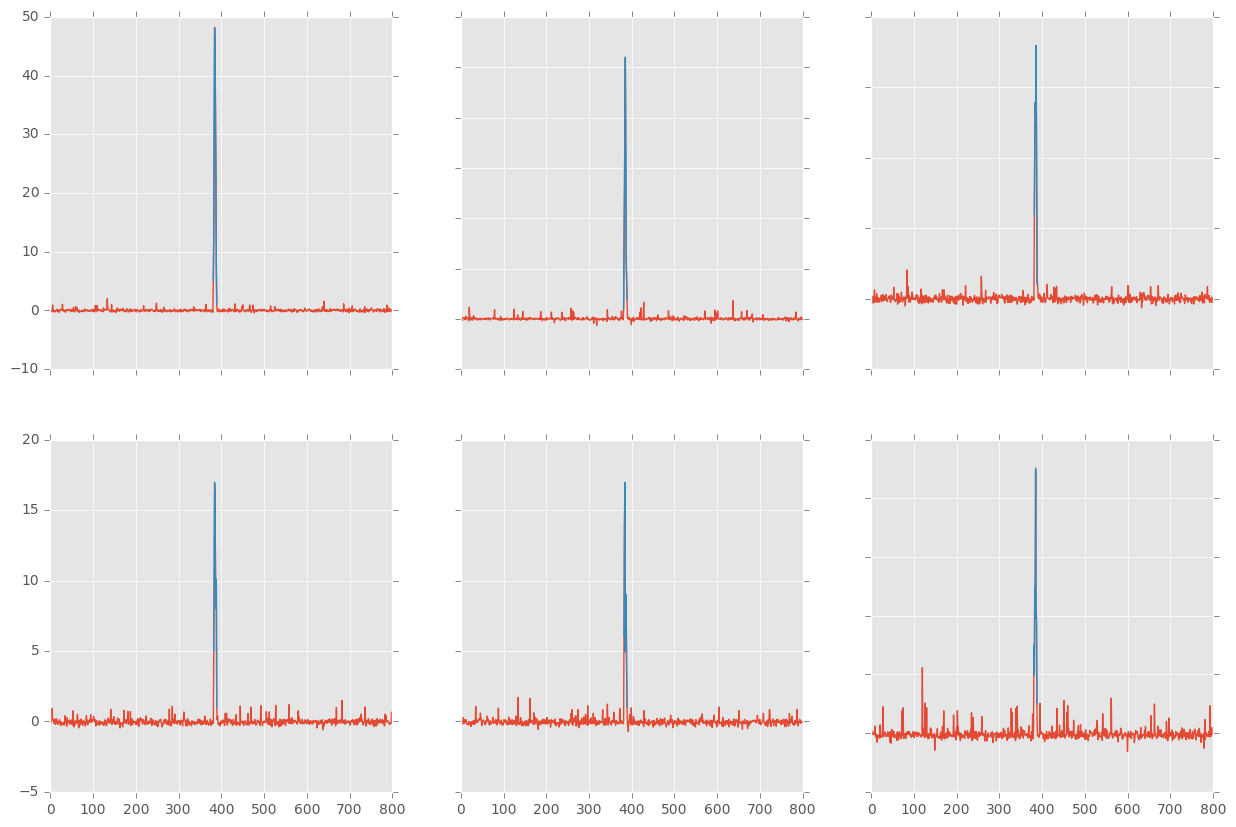

In [58]:
plotBestGroup(1)